In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Setting display options as per your style
pd.set_option('display.precision', 9)
pd.set_option('display.width', 150)

# Adams-Moulton (Implicit)

## Algorithm

1. Input
    * **System:** $\mathbf{Y}' = \mathbf{F}(x, \mathbf{Y})$
    * **Initial State:** $x_0, \mathbf{Y}_0$
    * **Order $s$:** Uses $s$ points including the implicit future point.

2. Coefficient Generation
    * **Predictor (Adams-Bashforth):**
        Integrate over $[0, 1]$ with nodes $0, -1, \dots, -(s-1)$.
    * **Corrector (Adams-Moulton):**
        Integrate over $[0, 1]$ with nodes $1, 0, -1, \dots, -(s-2)$.
        Resulting formula:
        $$\mathbf{Y}_{n+1} = \mathbf{Y}_n + h \left( \beta_0 \mathbf{F}_{n+1} + \sum_{j=1}^{s-1} \beta_j \mathbf{F}_{n-j+1} \right)$$

3. Iteration Loop

    For each step $n \to n+1$:

    1.  **Predict (Initialization):**
        Calculate initial guess $\mathbf{Y}_{n+1}^{(0)}$ using the explicit Adams-Bashforth formula.

    2.  **Evaluate & Correct (Fixed-Point Iteration):**
        
        Iterate $k = 0, 1, \dots$ until convergence:
    
    * **Evaluate:**:
        $\mathbf{F}_{n+1}^{(k)} = \mathbf{F}(x_{n+1}, \mathbf{Y}_{n+1}^{(k)})$

    * **Correct:**
        $$\mathbf{Y}_{n+1}^{(k+1)} = \mathbf{Y}_n + h \left( \beta_0 \mathbf{F}_{n+1}^{(k)} + \sum_{j=1}^{s-1} \beta_j \mathbf{F}_{n-j+1} \right)$$

    * **Check:** 
        If $||\mathbf{Y}_{n+1}^{(k+1)} - \mathbf{Y}_{n+1}^{(k)}|| < \epsilon$, stop.

    3.  **Update History:**
        Append $\mathbf{F}_{n+1}$ to history for the next step.

In [2]:
# --- 1. Coefficient Generators ---

def get_adams_bashforth_coeffs(s):
    """ Coefficients for Predictor (Explicit) """
    # Nodes: 0, -1, ..., -(s-1)
    nodes = -np.arange(s)
    return calc_coeffs(nodes, 0, 1)

def get_adams_moulton_coeffs(s):
    """ Coefficients for Corrector (Implicit) """
    # Nodes: 1, 0, -1, ..., -(s-2)
    # Total s nodes. Node 1 is the implicit point (n+1).
    nodes = np.concatenate(([1], -np.arange(s-1)))
    return calc_coeffs(nodes, 0, 1)

def calc_coeffs(nodes, a, b):
    """ Integrate Lagrange polynomials over [a, b] for given nodes """
    s = len(nodes)
    coeffs = []
    for j in range(s):
        roots = []
        denominator = 1.0
        for k in range(s):
            if k == j: continue
            roots.append(nodes[k])
            denominator *= (nodes[j] - nodes[k])
        
        poly_num = Polynomial.fromroots(roots)
        poly_int = poly_num.integ()
        val = (poly_int(b) - poly_int(a)) / denominator
        coeffs.append(val)
    return np.array(coeffs)

# --- 2. RK4 Stepper (Startup) ---
def rk4_step(F, x, Y, h):
    k1 = h * F(x, Y)
    k2 = h * F(x + 0.5*h, Y + 0.5*k1)
    k3 = h * F(x + 0.5*h, Y + 0.5*k2)
    k4 = h * F(x + h, Y + k3)
    return Y + (k1 + 2*k2 + 2*k3 + k4) / 6.0

In [4]:
# --- 3. Adams-Moulton System Solver ---
def adams_moulton_system_solve(F, x0, Y0, h, steps, s, tol=1e-9, max_iter=15):
    """
    Solves ODE system using Predictor-Corrector Adams-Moulton.
    Predictor: Adams-Bashforth (order s)
    Corrector: Adams-Moulton (order s)
    """
    Y0 = np.array(Y0, dtype=float)
    num_vars = len(Y0)
    
    # 1. Generate Coefficients
    # AB coeffs for prediction: [beta_0, ..., beta_{s-1}] corresponding to [F_n, ..., F_{n-s+1}]
    ab_betas = get_adams_bashforth_coeffs(s)
    
    # AM coeffs for correction: [beta_0, ..., beta_{s-1}] corresponding to [F_{n+1}, F_n, ..., F_{n-s+2}]
    # Note: am_betas[0] is the implicit coeff for F_{n+1}
    am_betas = get_adams_moulton_coeffs(s)
    
    # 2. Bootstrapping (RK4)
    # We need s-1 history points to start AB (which needs s points including current)
    # Wait, AB-s needs F_n ... F_{n-s+1}. We need s history points in memory.
    
    results = []
    f_history = [] # Stores [F_0, F_1, ...]
    
    x_curr = x0
    y_curr = Y0
    
    # Initial Point
    f_val = F(x_curr, y_curr)
    f_history.append(f_val)
    results.append({'n': 0, 'x': x_curr, 'y': y_curr.copy()})
    
    # Run RK4 to fill history up to step s-1
    # We need s points in history to run the first AB step at n=s-1 to predict n=s
    for i in range(1, s):
        y_next = rk4_step(F, x_curr, y_curr, h)
        x_next = x_curr + h
        
        y_curr = y_next
        x_curr = x_next
        f_val = F(x_curr, y_curr)
        f_history.append(f_val)
        
        results.append({'n': i, 'x': x_curr, 'y': y_curr.copy()})
        
    # 3. Main Loop
    # Starting from n = s-1 (last computed point), predicting n+1 = s
    
    for n in range(s-1, steps):
        # Current state: x_n, y_n (at index n in history, or just y_curr)
        # History available: F_0 ... F_n
        
        # --- PREDICTOR (Adams-Bashforth) ---
        # Y_{n+1}^P = Y_n + h * sum(ab_beta * history)
        # Get last s gradients: F_n, F_{n-1}, ..., F_{n-s+1}
        # Reverse to match ab_betas: [F_n, F_{n-1}...]
        
        ab_history = np.array(f_history[-s:])
        ab_history_rev = ab_history[::-1]
        
        y_pred = y_curr + h * np.dot(ab_betas, ab_history_rev)
        x_next = x_curr + h
        
        # --- CORRECTOR (Adams-Moulton) ---
        # Y_{n+1} = Y_n + h * (am_beta[0]*F_{n+1} + sum(am_beta[1:] * F_n...))
        
        # The 'known' part of the sum depends on F_n, F_{n-1}...
        # AM uses s points: F_{n+1}, F_n, ..., F_{n-s+2}
        # Known part uses s-1 points: F_n ... F_{n-s+2}
        
        am_history_known = np.array(f_history[-(s-1):]) # Last s-1 points
        am_history_known_rev = am_history_known[::-1]  # Order: F_n, F_{n-1}...
        
        # Pre-calculate explicit part of the sum
        explicit_sum = np.dot(am_betas[1:], am_history_known_rev)
        
        # Fixed Point Iteration
        y_corr = y_pred.copy()
        
        for k in range(max_iter):
            # Evaluate F at current guess
            f_next_est = F(x_next, y_corr)
            
            # Apply AM Formula
            # Y_{n+1} = Y_n + h * (beta_0 * F_{n+1} + explicit_sum)
            rhs = y_curr + h * (am_betas[0] * f_next_est + explicit_sum)
            
            # Check convergence
            err = np.linalg.norm(rhs - y_corr, ord=np.inf)
            y_corr = rhs
            
            if err < tol:
                break
        
        # Finalize Step
        y_curr = y_corr
        x_curr = x_next
        
        # Store new F
        f_val = F(x_curr, y_curr)
        f_history.append(f_val)
        
        results.append({'n': n + 1, 'x': x_curr, 'y': y_curr.copy()})

    # Formatting
    expanded_results = []
    for row in results:
        new_row = {'n': row['n'], 'x': row['x']}
        for i in range(num_vars):
            new_row[f'y{i}'] = row['y'][i]
        expanded_results.append(new_row)
        
    return pd.DataFrame(expanded_results)

## Result

In [5]:
# --- 4. Problem Definition (Example 5.10 from PDF) ---
# L*I'' + R*I' + Q/C = E(t)
# Variables: y0 = Q (Charge), y1 = I (Current)
# System:
# dQ/dt = I  => y0' = y1
# dI/dt = (E(t) - R*I - Q/C) / L => y1' = (E - R*y1 - y0/C) / L

def RLC_Circuit(x, Y):
    Q = Y[0]
    I = Y[1]
    
    # Constants from Example 5.10
    R = 30.0
    L = 2.0
    C = 0.016
    E = 50 * np.cos(10 * x) # E(t)
    
    dQ = I
    dI = (E - R*I - Q/C) / L
    
    return np.array([dQ, dI])

# Parameters
x0 = 0.0
Y0 = [0.0, 0.0] # Q(0)=0, I(0)=0
h = 0.05       # Step size (smaller for stability)
steps = 20
s = 4           # 4-step Adams-Bashforth

In [6]:
betas = get_adams_bashforth_coeffs(s)
betas

array([ 2.29166667, -2.45833333,  1.54166667, -0.375     ])

In [7]:
zetas = get_adams_moulton_coeffs(s)
zetas

array([ 0.375     ,  0.79166667, -0.20833333,  0.04166667])

In [8]:
# Solve
df_system = adams_moulton_system_solve(RLC_Circuit, x0, Y0, h, steps, s)
df_system

,n,x,y0,y1
0,0,0.00,0.000000000,0.000000000
1,1,0.05,0.024172671,0.823028691
2,2,0.10,0.071151474,0.950281851
3,3,0.15,0.111420260,0.591667716
4,4,0.20,0.125968734,-0.036670963
5,5,0.25,0.106919977,-0.715399817
6,6,0.30,0.056926254,-1.242157009
7,7,0.35,-0.012429881,-1.470032169
8,8,0.40,-0.084189487,-1.334376111
9,9,0.45,-0.140492255,-0.864465138


## Plotting the result

In [9]:
def plot_solver_result(df, mode, col1='x', col2='y_0', output_file='plot.png'):
    """
    Visualizes the solver output.
    
    Parameters:
    df : pd.DataFrame
        The solution table.
    mode : int
        1 for Time Series (x vs y).
        2 for Phase Plot (y_i vs y_j).
    col1 : str
        Name of the column for the X-axis.
    col2 : str
        Name of the column for the Y-axis.
    output_file : str
        Filename to save the image.
    """
    plt.figure(figsize=(10, 6))
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot Logic
    for item in col2:
        plt.plot(df[col1], df[item], label=f'{item} vs {col1}', linewidth=2, )
        plt.xlabel(col1, fontsize=12)
        plt.ylabel(item, fontsize=12)
    # Formatting
    plt.legend()
    
    if mode == 1:
        # Set the axis limits manually
        #plt.xlim(-10, 2000)       # Set x-axis range from 0 to 8
        #plt.ylim(-1.2, 1.2)  # Set y-axis range from -1.2 to 1.2

        plt.title(f"Mode 1: Time Series Plot ({col1} vs {col2})", fontsize=14)

    elif mode == 2:
        # Set the axis limits manually
        #plt.xlim(-10, 250)       # Set x-axis range from 0 to 8
        #plt.ylim(-1.2, 1.2)  # Set y-axis range from -1.2 to 1.2

        plt.title(f"Mode 2: Phase Plane Plot ({col1} vs {col2})", fontsize=14)

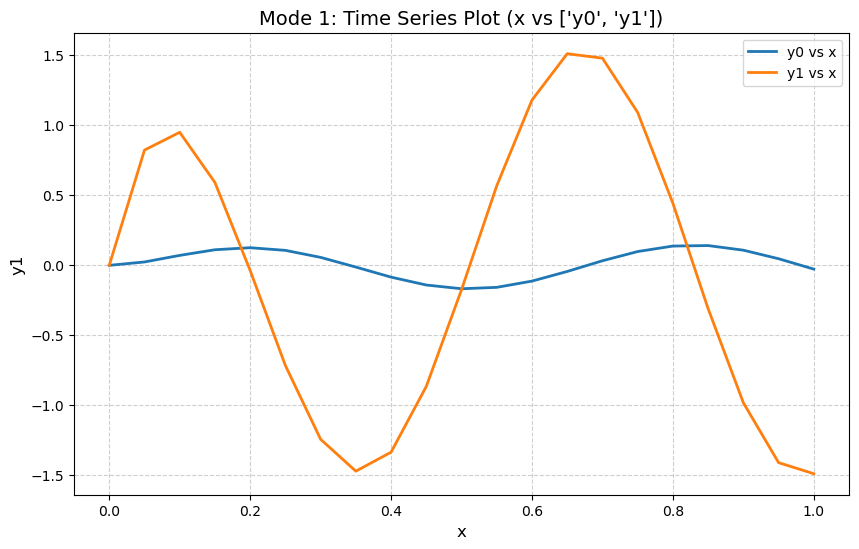

In [10]:
plot_solver_result(df_system, mode=1, col1='x', col2=['y0','y1'])